### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [82]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [83]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [84]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [85]:
# for loop to see appx performance over the whole sample with some rolling window

time0 = time.time()

#min_prd_list = range(100, 676, 25)
min_prd_list = [125]
windows_width = 3*12
cv_regularizer=0.05
optuna_trials = 40

results = pd.DataFrame(columns = ['min_prd', 'xgbf', 'xgbgs', 'xgbo'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:
    
    
    with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+2))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    display(df.shape, df.head(), df.year.describe(), df.count())
    
    df = df[(df.RET>-50)&(df.RET<75)]
    meanret = df.groupby('prd').RET.mean().to_frame().reset_index().rename(columns={'RET':'mRET'})
    df = pd.merge(df, meanret, on='prd', how='left')
    df.RET = df.RET-df.mRET
    df.drop(columns='mRET', inplace=True)

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    df.reset_index(inplace=True, drop=True)
    temp_cols = ['PERMNO', 'year']
    train = df[df.prd<(min_prd+windows_width)]
    test = df[df.prd==(min_prd+windows_width)]
    train.drop(columns=temp_cols, inplace=True)
    test.drop(columns=temp_cols, inplace=True)

    col_ignore = ['RET', 'prd']
    col_cat = ['ind']
    col_num = [x for x in train.columns if x not in col_ignore+col_cat]
    for col in col_num:
        train[col] = train[col].fillna(train[col].median())
        test[col] = test[col].fillna(train[col].median())
    for col in col_cat:
        train[col] = train[col].fillna(value=-1000)
        test[col] = test[col].fillna(value=-1000)

    X_train = train.copy()
    y_train = X_train.pop('RET')
    X_test = test.copy()
    y_test = X_test.pop('RET')
    y_train.reset_index(inplace=True, drop=True)

    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape)
    
    X_train0 = X_train.copy()
    y_train0 = y_train.copy()
    
    X_train.drop(columns=['remainder__prd'], inplace=True)
    X_test.drop(columns=['remainder__prd'], inplace=True)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
    xgb1.fit(X_train, y_train)
    print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))

    time1 = time.time()
    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02], 'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
    xgbm.fit(X_train, y_train)
    print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        temp_out = []

        for i in range(cv_runs):

            X = X_train
            y = y_train
            model = XGBRegressor(**params, njobs=-1)
            rkf = KFold(n_splits=n_splits, shuffle=True)
            X_values = X.values
            y_values = y.values
            y_pred = np.zeros_like(y_values)
            y_pred_train = np.zeros_like(y_values)
            for train_index, test_index in rkf.split(X_values):
                X_A, X_B = X_values[train_index, :], X_values[test_index, :]
                y_A, y_B = y_values[train_index], y_values[test_index]
                model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
                y_pred[test_index] = model.predict(X_B)
                y_pred_train[train_index] = model.predict(X_A)

            score_train = r2_score(y_train, y_pred_train)
            score_test = r2_score(y_train, y_pred) 
            overfit = (score_train-score_test)
            temp_out.append(score_test-cv_regularizer*overfit)

        return (np.mean(temp_out))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X_train, y_train)
    print('Optuna XGB train:', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

    # Evaluate performance of XGB models:
    r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
    r2_xgbgs = r2_score(y_test, xgbm.predict(X_test))
    r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

    print('Min_prd: ', min_prd)
    print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
          r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
    print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_xgbgs)
    print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)

    results.loc[results.min_prd==min_prd,'xgbf':'xgbo'] = r2_xgb1, r2_xgbgs, r2_xgbo
    
print(time.time()-time0, results)

(40682, 41)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l3amhd,l3MAX,l6amhd,l6MAX,l12amhd,l12MAX,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
49,10006,124,57.022356,27.230111,1968,-10.5198,25.0,-0.22327,0.183384,0.269118,0.100395,3.4619,12.086336,1.536049,1.377650,1.078594,0.854703,4.9820,1.945352,2.653852,2.174071,5.867580,-0.149515,0.173745,0.242714,0.119169,5.740148,1.573985,21.135115,1.636271,4.208600,1.653423,2.5316,1.833293,21.135115,6.066114,1.906794,1.545510,1.069805,1.668624,1.814489
50,10006,125,45.576895,32.149862,1968,-6.2596,25.0,-0.22327,0.183384,0.269118,0.100395,-10.5198,24.581595,1.493226,2.217285,1.948001,0.794842,2.7293,2.301335,2.797800,2.238881,5.751293,-0.149515,0.173745,0.242714,0.119169,5.660875,1.536049,4.982000,1.641999,2.202200,1.585251,1.7344,1.792446,4.982000,27.909142,1.503199,1.346875,1.007441,1.599164,1.760787
51,10006,126,16.380849,21.566933,1968,4.3219,25.0,-0.22327,0.183384,0.269118,0.100395,-6.2596,13.253947,1.469247,4.800074,4.663338,0.777908,7.2477,4.297812,3.251701,2.512787,5.691229,-0.149515,0.173745,0.242714,0.119169,5.648296,1.493226,2.729300,1.573985,21.135115,1.624355,2.1833,1.744677,2.729300,25.117139,1.051638,0.849621,0.989661,1.421761,1.677152
52,10006,127,32.954723,53.105785,1968,9.7618,25.0,-0.22327,0.183384,0.269118,0.100395,4.3219,11.098127,1.375395,1.477982,1.203894,0.787439,4.4095,1.764988,3.249921,2.531631,5.737749,-0.149515,0.173745,0.242714,0.119169,5.606947,1.469247,7.247700,1.536049,4.982000,1.636271,4.2086,1.727351,7.247700,26.865911,1.174851,1.018713,1.014681,1.442506,1.555119
53,10006,128,34.099293,39.415200,1968,3.9450,25.0,-0.22327,0.183384,0.269118,0.100395,9.7618,21.666549,1.246353,1.734429,1.621548,0.750551,5.4695,1.618184,3.253052,2.540064,5.824760,-0.149515,0.173745,0.242714,0.119169,5.549943,1.375395,4.409500,1.493226,2.729300,1.641999,2.2022,1.738743,4.409500,20.035787,1.903329,1.637691,0.996995,1.592287,1.605068


count    40682.000000
mean      1969.798437
std          0.978257
min       1968.000000
25%       1969.000000
50%       1970.000000
75%       1971.000000
max       1971.000000
Name: year, dtype: float64

PERMNO          40682
prd             40682
mom482          35826
mom242          40286
year            40682
RET             40682
ind             40682
bm              40682
op              40682
gp              40682
inv             40678
mom11           40682
mom122          40682
amhd            37268
ivol_capm       40681
ivol_ff5        40681
beta_bw         40682
MAX             40682
vol1m           40681
vol6m           40682
vol12m          40678
size            40682
lbm             40682
lop             40682
lgp             40682
linv            40682
llme            40682
l1amhd          37313
l1MAX           40682
l3amhd          37398
l3MAX           40682
l6amhd          37547
l6MAX           40682
l12amhd         37988
l12MAX          40682
l12mom122       40497
l12ivol_capm    40673
l12ivol_ff5     40673
l12beta_bw      40680
l12vol6m        40637
l12vol12m       40296
dtype: int64

Number of features before transformation:  (38133, 39)
time to do feature proprocessing: 
Number of features after transformation:  (38133, 83)
mae of a constant model 7.1541100803200415
R2 of a constant model 0.0
XGB train: 6.700516343240393 0.15021333381905422
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, eta

[I 2022-08-25 23:43:27,754] A new study created in memory with name: no-name-9eca9f6b-4114-4810-966c-63febb37fdcb


XGB train: 7.036265023358253 0.043365857443366185 34.7956383228302


[I 2022-08-25 23:43:29,951] Trial 0 finished with value: 0.0007022830264557848 and parameters: {'n_estimators': 513, 'max_depth': 3, 'learning_rate': 0.04698510052906226, 'colsample_bytree': 0.1366656960202447, 'subsample': 0.32336772226011057, 'alpha': 0.17971187437917585, 'lambda': 0.22115195905035534, 'gamma': 0.00017744203861825796, 'min_child_weight': 0.4370743069880602}. Best is trial 0 with value: 0.0007022830264557848.
[I 2022-08-25 23:43:34,340] Trial 1 finished with value: 0.006557888855663246 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.02926680509604762, 'colsample_bytree': 0.8627513865328104, 'subsample': 0.6211393036294219, 'alpha': 28.357384199786, 'lambda': 1.740805446283207, 'gamma': 1.1401796048386874e-06, 'min_child_weight': 12.238196946818995}. Best is trial 1 with value: 0.006557888855663246.
[I 2022-08-25 23:43:38,209] Trial 2 finished with value: 0.01131830000324923 and parameters: {'n_estimators': 664, 'max_depth': 4, 'learning_rate':

Total time for hypermarameter optimization  167.36829662322998
        n_estimators : 658
           max_depth : 5
       learning_rate : 0.010489766383071643
    colsample_bytree : 0.5230960308617957
           subsample : 0.7491435614259916
               alpha : 25.041485791983742
              lambda : 118.76939235347685
               gamma : 8.78786166241555
    min_child_weight : 6.313201660765905
best objective value : 0.0216817800698473
Optuna XGB train: 6.887444697503428 0.08431824162461499 170.29664659500122
Min_prd:  125
Constant guess:  6.801798451895731 0.0
XGB test: 6.690736270893462 0.001886781638528956
XGB GS test: 6.7089180299557585 0.006943571377436508
Optuna XGB test: 6.683955382866307 0.00471540944205473
207.5646300315857    min_prd      xgbf     xgbgs      xgbo
0      125  0.001887  0.006944  0.004715


In [86]:
results

,min_prd,xgbf,xgbgs,xgbo
0,125,0.001887,0.006944,0.004715


In [87]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  207.5944380760193


In [88]:
results.iloc[:,1:].mean()

xgbf     0.001887
xgbgs    0.006944
xgbo     0.004715
dtype: float64

In [60]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [61]:
results0

,min_prd,xgbf,xgbgs,xgbo
0,100,-0.033926,-0.019374,-0.02375
1,125,0.001887,0.006944,0.009033
2,150,0.009361,0.018258,0.018259
3,175,-0.008671,-0.002783,-0.000479
4,200,0.012099,0.01089,0.009292
5,225,0.024659,0.024404,0.025087
6,250,-0.004759,0.003918,0.006247
7,275,0.013317,0.017266,0.022251
8,300,-0.009404,-0.000589,-0.000884
9,325,-0.00607,0.004755,0.009447


In [132]:
# create validation set 
val_indx = X_train0.remainder__prd == min_prd+windows_width-1
X_val = X_train0[val_indx]
X_val.drop(columns='remainder__prd', inplace=True)
y_val = y_train0[val_indx]
display(X_val, y_val)
train_indx = X_train0.remainder__prd < min_prd+windows_width-1
X_train = X_train0[train_indx]
X_train.drop(columns='remainder__prd', inplace=True)
y_train = y_train0[train_indx]
display(X_train, y_train)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0
36,-0.612479,0.093461,0.719846,-0.253931,-0.987864,-0.395222,-0.839787,1.311527,-0.698449,-1.107615,-1.085305,-0.948009,-1.107851,-1.061303,-1.091215,-1.263500,0.728270,0.542291,-0.049710,-0.915318,-0.071219,0.559899,-0.568393,-1.113677,-0.409735,0.517731,-0.304907,-0.783420,-0.352128,-1.113677,-0.411241,-0.760507,-0.692327,-0.586912,-0.825575,-1.116346,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,-1.098087,-1.056204,1.111671,-1.729057,-0.621714,-0.126246,0.660355,-0.027070,1.122396,0.783425,0.489108,1.326108,0.371155,0.568497,0.759708,1.631631,-0.854679,0.452220,-0.846728,-0.549495,1.558847,-1.028437,1.177818,-0.535184,1.247437,3.053172,1.301634,0.122334,0.986915,-0.535184,-1.636807,1.061128,0.793389,1.587190,2.139835,1.972031,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,-1.017334,-0.761409,1.163306,-0.309223,-0.278237,-0.481448,-0.022911,0.048652,0.852550,-0.339425,-0.179673,-0.820050,-0.097148,-0.476122,-0.802269,-0.445159,-0.254341,0.442542,0.724077,0.114054,-0.820425,-0.272731,0.854642,0.216873,0.845819,-0.845943,0.993837,1.109063,0.993492,0.216873,-1.113882,-0.611153,-0.402149,-1.157941,-0.417698,-0.258807,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,-1.100278,0.032686,1.092450,-0.504720,-0.889660,-0.659544,-1.199866,1.311926,-0.833087,-0.445394,-0.390569,0.285349,-0.821593,-0.403480,-0.736434,-0.756806,0.622390,1.436114,-0.562715,-0.848914,-0.316655,0.449012,-0.691659,-0.941756,-0.533623,-0.683832,-0.445939,-0.706069,-0.499549,-0.941756,-0.972298,0.549475,0.642682,0.364889,0.145648,-0.157740,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,-0.760740,0.149421,1.087237,-0.416474,-0.963139,-0.602710,-0.484662,1.991333,-1.277050,-0.865144,-0.816650,0.219649,-0.739330,-0.826352,-0.666444,-0.748998,1.354701,0.958646,-0.268558,-0.894380,-0.716941,1.088137,-1.165634,0.158669,-1.071988,-0.215578,-0.998049,-0.794888,-1.066169,0.158669,-1.147174,0.641499,0.811720,0.080118,-0.033113,-0.319384,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

36       11.636391
73      -14.450009
98        8.057591
135       7.106191
172       5.680091
           ...    
38054     3.070491
38056     4.701091
38093     3.527791
38095   -11.022609
38132    -4.772609
Name: RET, Length: 1264, dtype: float64

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0
0,0.223712,0.411154,0.517180,0.607708,-0.658944,-0.306924,0.378862,0.401231,-1.035214,-0.744129,-0.843638,-0.665956,-0.141294,-0.399484,0.074478,-0.405186,0.859184,0.593453,0.376156,-0.827453,-0.241889,0.781835,-1.007636,4.200045,-0.956844,-0.387515,-0.921897,-0.820376,-0.768271,4.200045,-0.021914,-0.256914,-0.356260,-0.051503,-0.783741,-0.658663,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.086569,0.493729,0.517180,0.607708,-0.658944,-0.306924,-0.918057,0.728623,-1.061755,-0.018037,0.006479,-0.834701,-0.750279,-0.116693,0.207577,-0.341607,0.792355,0.593453,0.376156,-0.827453,-0.241889,0.734604,-1.031290,-0.150671,-0.953228,-0.921780,-0.965768,-1.034487,-0.795208,-0.150671,0.496798,-0.620918,-0.559273,-0.221874,-0.853985,-0.716271,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.263268,0.316102,0.517180,0.607708,-0.658944,-0.306924,-0.522888,0.431824,-1.076616,2.215483,2.661567,-0.882438,0.471206,1.469296,0.627268,-0.072902,0.757836,0.593453,0.376156,-0.827453,-0.241889,0.727109,-1.057992,-0.757418,-0.996169,4.119681,-0.940603,-0.913922,-0.826711,-0.757418,0.430496,-1.028182,-1.067485,-0.270448,-1.033392,-0.805989,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.064674,0.845461,0.517180,0.607708,-0.658944,-0.306924,0.458634,0.375338,-1.134783,-0.657365,-0.721118,-0.855571,-0.296061,-0.542764,0.625622,-0.054416,0.784571,0.593453,0.376156,-0.827453,-0.241889,0.702473,-1.072944,0.459578,-1.020119,-0.181574,-0.932934,-0.369970,-0.838137,0.459578,0.472025,-0.917057,-0.894666,-0.202096,-1.012412,-0.936897,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.050959,0.615673,0.517180,0.607708,-0.658944,-0.306924,0.963230,0.652245,-1.214758,-0.435597,-0.312731,-0.959557,-0.009505,-0.659384,0.628517,-0.046143,0.834576,0.593453,0.376156,-0.827453,-0.241889,0.668511,-1.131465,-0.304869,-1.047156,-0.781423,-0.929248,-0.908846,-0.830624,-0.304869,0.309828,-0.260039,-0.262048,-0.250413,-0.860940,-0.883314,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

0       -13.789167
1       -12.370234
2         3.534886
3         3.438924
4         4.611103
           ...    
38127     0.887722
38128    -8.021688
38129    22.542507
38130     6.212760
38131    -0.103652
Name: RET, Length: 36869, dtype: float64

In [249]:
### try SnNN  

neurons_base = 4
dropout_rate = 0.00

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"), 
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"), 
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"), 
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

# tf.keras.layers.AlphaDropout(0.4) if needed
print(model_snn.count_params())
#model_snn.summary()

54917
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1355 (Dense)           (None, 128)               10624     
_________________________________________________________________
alpha_dropout_358 (AlphaDrop (None, 128)               0         
_________________________________________________________________
dense_1356 (Dense)           (None, 128)               16512     
_________________________________________________________________
alpha_dropout_359 (AlphaDrop (None, 128)               0         
_________________________________________________________________
dense_1357 (Dense)           (None, 64)                8256      
_________________________________________________________________
alpha_dropout_360 (AlphaDrop (None, 64)                0         
_________________________________________________________________
dense_1358 (Dense)           (None, 64)        

In [533]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

217601


In [620]:
neurons_base = 16
dropout_rate = 0.05

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*27, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*9, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*3, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

105969


Epoch 1/1000
19/19 - 1s - loss: 93.4900 - mean_squared_error: 93.4900 - val_loss: 101.1570 - val_mean_squared_error: 101.1570
Epoch 2/1000
19/19 - 0s - loss: 92.9929 - mean_squared_error: 92.9929 - val_loss: 98.8929 - val_mean_squared_error: 98.8929
Epoch 3/1000
19/19 - 0s - loss: 93.0172 - mean_squared_error: 93.0172 - val_loss: 99.9819 - val_mean_squared_error: 99.9819
Epoch 4/1000
19/19 - 0s - loss: 92.8174 - mean_squared_error: 92.8174 - val_loss: 100.5657 - val_mean_squared_error: 100.5657
Epoch 5/1000
19/19 - 0s - loss: 92.6527 - mean_squared_error: 92.6527 - val_loss: 100.6618 - val_mean_squared_error: 100.6618
Epoch 6/1000
19/19 - 0s - loss: 92.7658 - mean_squared_error: 92.7658 - val_loss: 101.9710 - val_mean_squared_error: 101.9710
Epoch 7/1000
19/19 - 0s - loss: 92.6335 - mean_squared_error: 92.6335 - val_loss: 100.8951 - val_mean_squared_error: 100.8951
Epoch 8/1000
19/19 - 0s - loss: 92.5593 - mean_squared_error: 92.5593 - val_loss: 100.1218 - val_mean_squared_error: 100.1

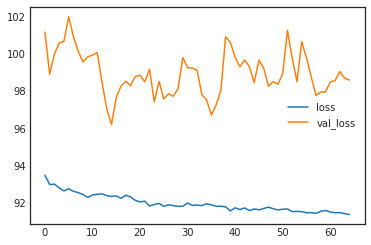

In [621]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [180]:
X_val

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0
36,-0.612479,0.093461,0.719846,-0.253931,-0.987864,-0.395222,-0.839787,1.311527,-0.698449,-1.107615,-1.085305,-0.948009,-1.107851,-1.061303,-1.091215,-1.263500,0.728270,0.542291,-0.049710,-0.915318,-0.071219,0.559899,-0.568393,-1.113677,-0.409735,0.517731,-0.304907,-0.783420,-0.352128,-1.113677,-0.411241,-0.760507,-0.692327,-0.586912,-0.825575,-1.116346,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,-1.098087,-1.056204,1.111671,-1.729057,-0.621714,-0.126246,0.660355,-0.027070,1.122396,0.783425,0.489108,1.326108,0.371155,0.568497,0.759708,1.631631,-0.854679,0.452220,-0.846728,-0.549495,1.558847,-1.028437,1.177818,-0.535184,1.247437,3.053172,1.301634,0.122334,0.986915,-0.535184,-1.636807,1.061128,0.793389,1.587190,2.139835,1.972031,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,-1.017334,-0.761409,1.163306,-0.309223,-0.278237,-0.481448,-0.022911,0.048652,0.852550,-0.339425,-0.179673,-0.820050,-0.097148,-0.476122,-0.802269,-0.445159,-0.254341,0.442542,0.724077,0.114054,-0.820425,-0.272731,0.854642,0.216873,0.845819,-0.845943,0.993837,1.109063,0.993492,0.216873,-1.113882,-0.611153,-0.402149,-1.157941,-0.417698,-0.258807,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,-1.100278,0.032686,1.092450,-0.504720,-0.889660,-0.659544,-1.199866,1.311926,-0.833087,-0.445394,-0.390569,0.285349,-0.821593,-0.403480,-0.736434,-0.756806,0.622390,1.436114,-0.562715,-0.848914,-0.316655,0.449012,-0.691659,-0.941756,-0.533623,-0.683832,-0.445939,-0.706069,-0.499549,-0.941756,-0.972298,0.549475,0.642682,0.364889,0.145648,-0.157740,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,-0.760740,0.149421,1.087237,-0.416474,-0.963139,-0.602710,-0.484662,1.991333,-1.277050,-0.865144,-0.816650,0.219649,-0.739330,-0.826352,-0.666444,-0.748998,1.354701,0.958646,-0.268558,-0.894380,-0.716941,1.088137,-1.165634,0.158669,-1.071988,-0.215578,-0.998049,-0.794888,-1.066169,0.158669,-1.147174,0.641499,0.811720,0.080118,-0.033113,-0.319384,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.